# Combine Files from FoodData

In [1]:
import pandas as pd
import numpy as np

import requests
import re
import urllib.request

from glob import glob
import shutil
import os

from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import logging

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)


In [2]:
!ls -GFlash

total 292K
4.0K drwxrwxr-x 10 robmulla 4.0K Feb  2 22:44 ./
4.0K drwxrwxr-x 57 robmulla 4.0K Feb  2 21:37 ../
 60K -rw-rw-r--  1 robmulla  58K Jun 30  2022 eda-2022-data.ipynb
4.0K drwxrwxr-x  2 robmulla 4.0K Feb  2 22:29 FoodData_Central_csv_2019-12-17/
4.0K drwxrwxr-x  3 robmulla 4.0K Feb  2 22:45 FoodData_Central_csv_2020-04-29/
4.0K drwxrwxr-x  3 robmulla 4.0K Feb  2 22:45 FoodData_Central_csv_2020-10-30/
4.0K drwxrwxr-x  2 robmulla 4.0K Feb  2 22:29 FoodData_Central_csv_%202019-04-02/
4.0K drwxrwxr-x  3 robmulla 4.0K Feb  2 22:45 FoodData_Central_csv_2021-04-28/
4.0K drwxrwxr-x  3 robmulla 4.0K Feb  2 22:45 FoodData_Central_csv_2021-10-28/
4.0K drwxrwxr-x  3 robmulla 4.0K Feb  2 22:45 FoodData_Central_csv_2022-04-28/
4.0K drwxrwxr-x  2 robmulla 4.0K Feb  2 22:28 FoodData_Central_csv_2022-10-28/
8.0K -rw-rw-r--  1 robmulla 7.5K Feb  2 22:29 fooddata-central-data-scrape.ipynb
 12K -rw-rw-r--  1 robmulla  11K Feb  2 21:22 usda-food-data-pull.ipynb
172K -rw-rw-r--  1 robmulla 171K Feb

# Move all files 2 directories deep, up one directory

- Could have used Pathlib
    `Path().resolve().parents[1]` -> one dir up

In [3]:
files_to_move = glob('./*/*/*.csv')

for fn in files_to_move:
    # Move the file up one directory
    new_filename = fn.split('/')[1] + '/' + fn.split('/')[-1]
    os.rename(fn, new_filename)

# Look at All Branded Food

In [4]:
branded_csvs = glob('*/branded_food.csv')

In [5]:
branded_csvs[0]

'FoodData_Central_csv_2022-10-28/branded_food.csv'

In [6]:
df = pd.read_csv(branded_csvs[0], low_memory=False)

In [7]:
df.columns

Index(['fdc_id', 'brand_owner', 'brand_name', 'subbrand_name', 'gtin_upc',
       'ingredients', 'not_a_significant_source_of', 'serving_size',
       'serving_size_unit', 'household_serving_fulltext',
       'branded_food_category', 'data_source', 'package_weight',
       'modified_date', 'available_date', 'market_country',
       'discontinued_date', 'preparation_state_code', 'trade_channel',
       'short_description'],
      dtype='object')

In [8]:
%load_ext lab_black

<AxesSubplot: title={'center': 'Top Brand Food Categories'}>

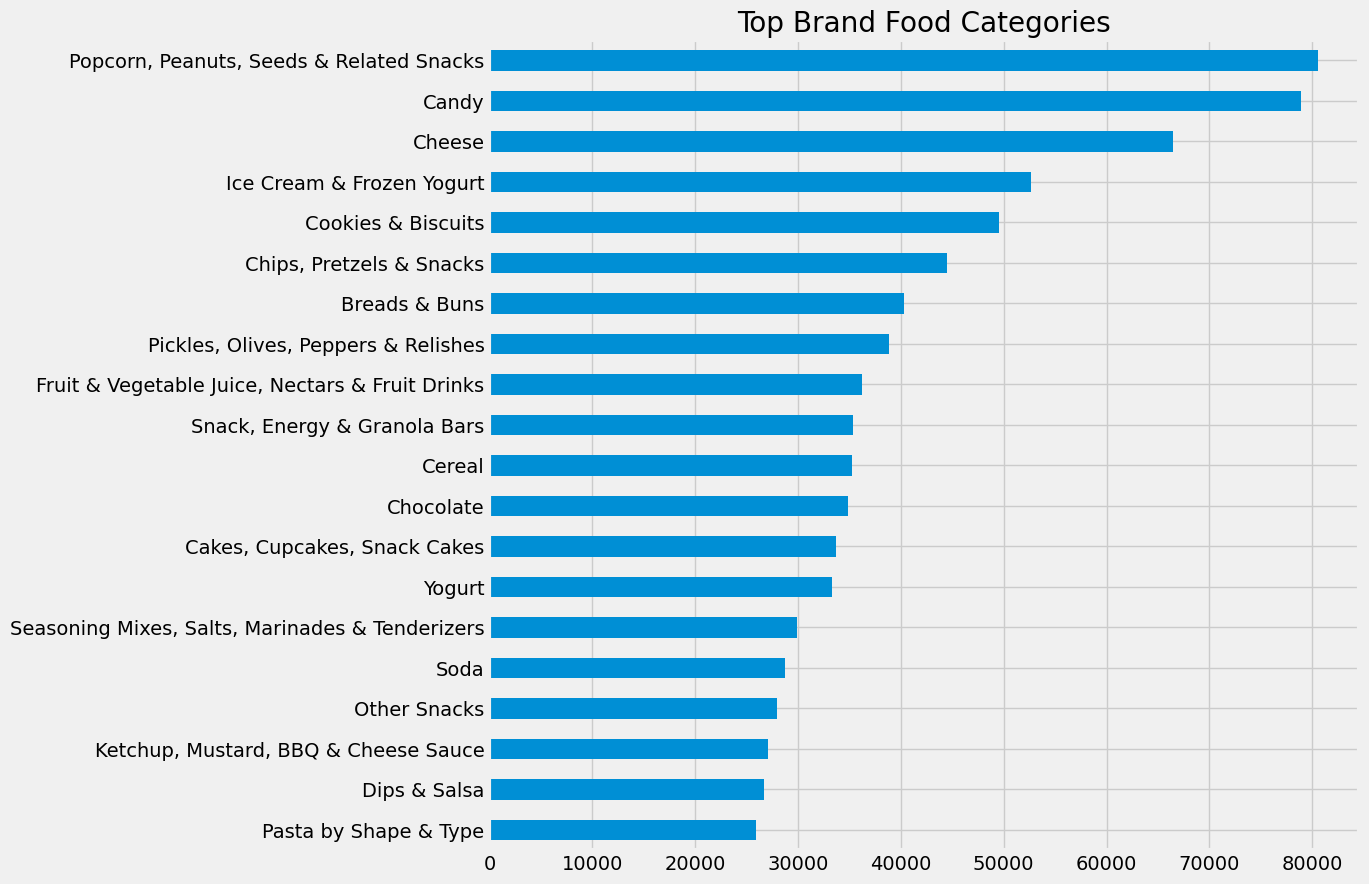

In [9]:
df["branded_food_category"].value_counts().head(20).sort_values().plot(
    kind="barh", figsize=(10, 10), title="Top Brand Food Categories"
)

## Can We find tacos?!

In [10]:
df["branded_food_category"] = df["branded_food_category"].astype("category")

In [11]:
df_taco_shells = df.loc[
    df["branded_food_category"].str.contains("taco", flags=re.IGNORECASE).fillna(False)
].copy()

# Lets Compare Non Alcoholic Beverages (Ready to Drink)!

In [12]:
sodas = df.loc[
    df["branded_food_category"] == "Non Alcoholic Beverages  Ready to Drink"
].copy()

In [13]:
# # convert grams to milliliters
# gram_to_ml = 1 / 0.001

# sodas.loc[sodas["serving_size_unit"] == "g", "serving_size"] / 0.001

In [14]:
sodas["serving_size"].value_counts()

360.0    2440
240.0    1211
600.0     397
225.0     246
507.0     222
         ... 
80.0        2
960.0       1
500.0       1
90.0        1
85.0        1
Name: serving_size, Length: 67, dtype: int64

In [15]:
# sodas.loc[sodas["serving_size_unit"] == "g"]["serving_size"].value_counts()

In [16]:
food = pd.read_csv("FoodData_Central_csv_2022-10-28/food.csv")
sodas = sodas.merge(food, how="left", validate="1:1")

In [17]:
sodas.columns

Index(['fdc_id', 'brand_owner', 'brand_name', 'subbrand_name', 'gtin_upc',
       'ingredients', 'not_a_significant_source_of', 'serving_size',
       'serving_size_unit', 'household_serving_fulltext',
       'branded_food_category', 'data_source', 'package_weight',
       'modified_date', 'available_date', 'market_country',
       'discontinued_date', 'preparation_state_code', 'trade_channel',
       'short_description', 'data_type', 'description', 'food_category_id',
       'publication_date'],
      dtype='object')

In [18]:
sodas.sort_values("serving_size", ascending=False)[
    [
        "fdc_id",
        "brand_owner",
        "brand_name",
        "description",
        "serving_size",
        "short_description",
    ]
].head()

,fdc_id,brand_owner,brand_name,description,serving_size,short_description
492,761820,QTG,NaN,Gatorade Fierce Bold & Intense Strawberry Thir...,960.0,NaN
4863,2317437,POLAR BEVERAGES,POLAR,24OZ SPORT BOTTLE SPRING WATER,720.0,SPRING WATER
5199,2330781,POLAR BEVERAGES,POLAR,24OZ SPORT BOTTLE SPRING WATER,720.0,SPRING WATER
3701,2228873,POLAR BEVERAGES,POLAR,Plastic Bottle,720.0,SPRING WATER
4496,2235283,POLAR BEVERAGES,POLAR,Plastic Bottle,720.0,SPRING WATER


# Pull in food_nutrient info

In [19]:
nutrient = pd.read_csv("FoodData_Central_csv_2022-10-28/food_nutrient.csv")

/tmp/ipykernel_1105458/497835586.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  nutrient = pd.read_csv("FoodData_Central_csv_2022-10-28/food_nutrient.csv")


In [20]:
sodas.loc[
    sodas["brand_name"].str.contains("Zero", flags=re.IGNORECASE).fillna(False)
].head()

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description,data_type,description,food_category_id,publication_date
2217,1460784,The Coca-Cola Company,Coca-Cola Zero,Coca-Cola Cherry Zero,00049000047547,"CARBONATED WATER, CARAMEL COLOR, PHOSPHORIC AC...",NaN,600.0,ml,NaN,Non Alcoholic Beverages Ready to Drink,GDSN,20 OZA,2019-02-12,2021-03-19,United States,NaN,NaN,NaN,NaN,branded_food,Coke Chry Zero 20OZA PL BT,NaN,2021-03-19
2243,1460841,The Coca-Cola Company,Blue Sky Zero-KO,Blue Sky Zero Cherry Vanilla-KO,00049000069686,"CARBONATED FILTERED WATER, ERYTHRITOL, MALTODE...",NaN,360.0,ml,NaN,Non Alcoholic Beverages Ready to Drink,GDSN,12 OZA,2019-04-26,2021-03-19,United States,NaN,NaN,NaN,NaN,branded_food,Blue Sky Zero Chry Vnl 12OZA AL CN,NaN,2021-03-19
2258,1461253,The Coca-Cola Company,Blue Sky Zero-KO,Blue Sky Zero Lemon Lime-KO,00049000069747,"INGREDIENTS: CARBONATED FILTERED WATER, ERYTHR...",NaN,360.0,ml,NaN,Non Alcoholic Beverages Ready to Drink,GDSN,12 OZA,2019-04-26,2021-03-19,United States,NaN,NaN,NaN,NaN,branded_food,Blue Sky Zero Lmn Lime 12OZA AL CN,NaN,2021-03-19
2260,1461260,The Coca-Cola Company,Blue Sky Zero-KO,Blue Sky Zero Root Beer-KO,00049000069761,"CARBONATED FILTERED WATER, ERYTHRITOL, NATURAL...",NaN,360.0,ml,NaN,Non Alcoholic Beverages Ready to Drink,GDSN,12 OZA,2018-10-01,2021-03-19,United States,NaN,NaN,NaN,NaN,branded_food,Blue Sky Zero Rt Br-KO 12OZA AL CN,NaN,2021-03-19
2261,1461262,The Coca-Cola Company,Blue Sky Zero-KO,Blue Sky Zero Cola-KO,00049000069709,"CARBONATED FILTERED WATER, ERYTHRITOL, NATURAL...",NaN,360.0,ml,NaN,Non Alcoholic Beverages Ready to Drink,GDSN,12 OZA,2019-04-26,2021-03-19,United States,NaN,NaN,NaN,NaN,branded_food,Blue Sky Zero Cola-KO 12OZA AL CN,NaN,2021-03-19


In [21]:
soda_ids = sodas["fdc_id"].unique()

In [22]:
soda_nutrients = nutrient.query("fdc_id in @soda_ids").reset_index(drop=True).copy()
nut_details = pd.read_csv("FoodData_Central_csv_2022-10-28/nutrient.csv")
soda_nutrients = soda_nutrients.merge(
    nut_details,
    left_on="nutrient_id",
    right_on="id",
    how="left",
    validate="m:1",
    suffixes=("", "_nutrient"),
)
soda_nutrients = soda_nutrients.merge(
    food, on="fdc_id", how="left", validate="m:1", suffixes=("", "_food")
)


soda_nutrients = soda_nutrients.merge(
    sodas, on="fdc_id", how="left", validate="m:1", suffixes=("", "_branded")
)

In [23]:
soda_nutrients.shape

(113782, 44)

In [24]:
soda_nutrient_pivot = (
    soda_nutrients.groupby(["fdc_id", "name"])["amount"].sum().unstack().fillna(0)
).copy()

In [25]:
# food.head()

In [26]:
soda_nutrients.columns

Index(['id', 'fdc_id', 'nutrient_id', 'amount', 'data_points', 'derivation_id',
       'min', 'max', 'median', 'loq', 'footnote', 'min_year_acquired',
       'id_nutrient', 'name', 'unit_name', 'nutrient_nbr', 'rank', 'data_type',
       'description', 'food_category_id', 'publication_date', 'brand_owner',
       'brand_name', 'subbrand_name', 'gtin_upc', 'ingredients',
       'not_a_significant_source_of', 'serving_size', 'serving_size_unit',
       'household_serving_fulltext', 'branded_food_category', 'data_source',
       'package_weight', 'modified_date', 'available_date', 'market_country',
       'discontinued_date', 'preparation_state_code', 'trade_channel',
       'short_description', 'data_type_branded', 'description_branded',
       'food_category_id_branded', 'publication_date_branded'],
      dtype='object')

In [29]:
soda_nutrients.query('brand_name != "POLAR"').query('name == "Energy"').sort_values(
    "amount", ascending=False
)[
    [
        "description",
        "amount",
        "serving_size",
        "data_type_branded",
        "branded_food_category",
        "brand_owner",
        "brand_name",
        "subbrand_name",
        "unit_name",
    ]
].head(
    5
)

,description,amount,serving_size,data_type_branded,branded_food_category,brand_owner,brand_name,subbrand_name,unit_name
21218,Cherry Coke 7.5OZA AL CN,1333.0,225.0,branded_food,Non Alcoholic Beverages Ready to Drink,The Coca-Cola Company-0049000000016,NaN,NaN,KCAL
67992,Coca-Cola Cherry 7.5 fluid ounce (US) Non-Refi...,1333.0,225.0,branded_food,Non Alcoholic Beverages Ready to Drink,The Coca-Cola Company,Coca-Cola,Coca-Cola Cherry,KCAL
92153,Coca-Cola Cherry 7.5 fluid ounce (US) Non-Refi...,1333.0,225.0,branded_food,Non Alcoholic Beverages Ready to Drink,The Coca-Cola Company,Coca-Cola,Coca-Cola Cherry,KCAL
35201,Coca-Cola Cherry 7.5 fluid ounce (US) Non-Refi...,1333.0,225.0,branded_food,Non Alcoholic Beverages Ready to Drink,The Coca-Cola Company,Coca-Cola,Coca-Cola Cherry,KCAL
56005,Coca-Cola Cherry 7.5 fluid ounce (US) Non-Refi...,1333.0,225.0,branded_food,Non Alcoholic Beverages Ready to Drink,The Coca-Cola Company,Coca-Cola,Coca-Cola Cherry,KCAL


In [37]:
soda_nutrients.loc[
    soda_nutrients["description"]
    .str.contains("Rockstar", flags=re.IGNORECASE)
    .fillna(False)
].sort_values("amount", ascending=False)[
    [
        "description",
        "amount",
        "serving_size",
        "data_type_branded",
        "branded_food_category",
        "brand_owner",
        "brand_name",
        "subbrand_name",
        "unit_name",
    ]
]

,description,amount,serving_size,data_type_branded,branded_food_category,brand_owner,brand_name,subbrand_name,unit_name
26775,Rockstar Pure Zero Silver Ice Energy Drink 16 ...,75.0,240.0,branded_food,Non Alcoholic Beverages Ready to Drink,Rockstar International,Rockstar,NaN,MG
9496,Rockstar Pure Zero Silver Ice Energy Drink 16 ...,75.0,240.0,branded_food,Non Alcoholic Beverages Ready to Drink,ROCKSTAR INC.,NaN,NaN,MG
10034,ROCKSTAR PURE ZERO PUNCH 16Z CN,75.0,240.0,branded_food,Non Alcoholic Beverages Ready to Drink,ROCKSTAR INC.,NaN,NaN,MG
27309,ROCKSTAR PURE ZERO PUNCH 16Z CN,75.0,240.0,branded_food,Non Alcoholic Beverages Ready to Drink,Rockstar International,Rockstar,NaN,MG
29893,Rockstar Punched 16 fluid ounce can,54.0,240.0,branded_food,Non Alcoholic Beverages Ready to Drink,Rockstar International,Rockstar,NaN,KCAL
...,...,...,...,...,...,...,...,...,...
26953,Rockstar Sugar Free Energy Drink 16 Fluid Ounc...,0.0,240.0,branded_food,Non Alcoholic Beverages Ready to Drink,Rockstar International,Rockstar,NaN,KCAL
26952,Rockstar Sugar Free Energy Drink 16 Fluid Ounc...,0.0,240.0,branded_food,Non Alcoholic Beverages Ready to Drink,Rockstar International,Rockstar,NaN,G
26951,Rockstar Sugar Free Energy Drink 16 Fluid Ounc...,0.0,240.0,branded_food,Non Alcoholic Beverages Ready to Drink,Rockstar International,Rockstar,NaN,G
11699,Rockstar 0 Carb Energy Drink 16 Fluid Ounce Al...,0.0,240.0,branded_food,Non Alcoholic Beverages Ready to Drink,ROCKSTAR INC.,NaN,NaN,G
